In [241]:
import sys
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.cd_cnce import CdCnceCrit
from src.nce.cd_mh import CdMHCrit
from src.nce.per_cnce import PersistentCondNceCrit

from src.noise_distr.rbm_noise_distr import RbmNoiseDistr
from src.noise_distr.bernoulli import MultivariateBernoulli, ConditionalMultivariateBernoulli

from src.models.rbm.rbm import Rbm
from src.data.mnist import MnistDataset

from src.training.model_training import train_model
from src.training.training_utils import no_stopping

from src.experiments.noise_distr_utils import get_nce_noise_distr_par, get_cnce_noise_distr_par
from src.experiments.mnist_exp_utils import initialise_params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## HELP FUNCTIONS

In [256]:
def get_nce_noise_distr_par(y):
    return y.mean(dim=0)

In [257]:
def get_cnce_noise_distr_par(y):
    return torch.tensor([y[y <= 0.5].mean()] * y.shape[-1]), torch.tensor([y[y > 0.5].mean()] * y.shape[-1])

## EXPERIMENTS

In [242]:
# Data specs
num_dims = 28**2

# Training specs
num_neg_samples = 2
lr = 0.1
batch_size = 100
num_epochs = 100

In [243]:
# Check accuracy of model
def rbm_acc(rbm, data_loader, k=100):
    acc = 0
    for i, (y, idx) in enumerate(data_loader, 0):
        y_pred = rbm.sample(y, k=k)
        acc += (y_pred == y).type(torch.float).mean(dim=-1).sum()
        
    return acc / len(data_loader.dataset)

def placeholder_metric(model):
    return model.weights.mean()

In [244]:
# Configurations to consider in experiments 

config_conditional_multi = {
    "criterion": CdCnceCrit,
    "label": "cd_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
}

config_per_cnce = {
    "criterion": PersistentCondNceCrit,
    "label": "cd_cnce",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": None,
}

config_cd_mh = {
    "criterion": CdMHCrit,
    "label": "cd_mh",
    "estimate_part_fn": False,
    "conditional_noise_distr": True,
    "mcmc_steps": 1,
}


configs = [config_cd_mh]

In [250]:
# Get data 
training_data = MnistDataset(train=True, root_dir="../src/data/datasets/")
training_data.y = training_data.y[:10000, :]
training_data.num_samples = 10000
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
                             
test_data = MnistDataset(train=False, root_dir="../src/data/datasets/")
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [262]:
nce_p = get_nce_noise_distr_par(training_data.get_full_data())
cnce_p0, cnce_p1 = get_cnce_noise_distr_par(training_data.get_full_data())

In [263]:
# Initialise model       
weights, vis_bias, hidden_bias = initialise_params()

In [264]:
# Run experiments

for config in configs:

    # Make sure that these are "reinitialised"
    p_m, p_n, criterion = None, None, None

    p_m = Rbm(weights=weights.clone(), vis_bias=vis_bias.clone(), hidden_bias=hidden_bias.clone())
    
    if config["conditional_noise_distr"]:
        p_n = ConditionalMultivariateBernoulli(cnce_p0, cnce_p1)
    else:
        p_n = ConditionalMultivariateBernoulli(nce_p)
   
    if config["mcmc_steps"] is not None:
        criterion = config["criterion"](p_m, p_n, num_neg_samples, config["mcmc_steps"])
    else:
        criterion = config["criterion"](p_m, p_n, num_neg_samples)

    save_dir = None
    _ = train_model(criterion, placeholder_metric, train_loader, save_dir, num_epochs=num_epochs,
                    decaying_lr=True, weight_decay=1e-3, stopping_condition=no_stopping)
    
    # Check test accuracy of model
    acc = rbm_acc(p_m, test_loader)
    print("Model accuracy: {}".format(acc))
    
    # Save model
    torch.save(p_m.state_dict(), "res/params_" + config["label"])


Finished training
Model accuracy: 0.7847861647605896


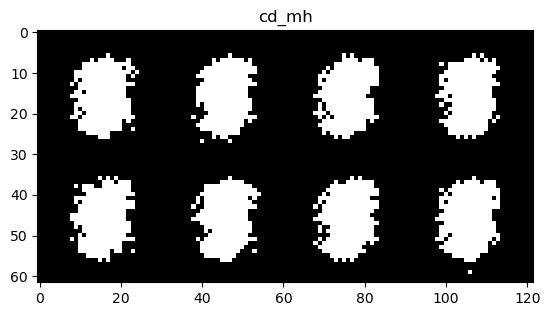

In [265]:
# Visualise results

num_samples = 8

p_m = Rbm(weights=weights.clone(), vis_bias=vis_bias.clone(), hidden_bias=hidden_bias.clone())
for config in configs:
    p_m.load_state_dict(torch.load("res/params_" + config["label"]))
    y_pred = p_m.sample(training_data.y[:num_samples, :], k=100) # Eller hur fungerar detta? torch.randn((num_samples, num_dims))?
    
    plt.imshow(np.transpose(torchvision.utils.make_grid(y_pred.reshape(-1, 1, 28, 28), nrow=4).numpy(), (1, 2, 0)))
    plt.title(config["label"])
    plt.show()